In [1]:
%load_ext autoreload
%autoreload 2
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [2]:
from star_analysis.data.configs import SdssDatasetConfig
from star_analysis.data.datasets import Sdss

dataset = Sdss(
    config=SdssDatasetConfig(
        patch_shape=None,
        prepare=True,
        include_test_set=True,
        include_train_set=False
    )
)
len(dataset)

[INFO][2023-07-07 17:48:30,256] image_downloader.py:download_exact:62: Downloading 8162 6 0080
[INFO][2023-07-07 17:48:53,495] image_downloader.py:download:46: Downloading 8162


Found 1 data/label pairs


1

In [3]:
import torch
from star_analysis.model.neural_networks.losses.utils import compute_distance_map

x, y = dataset[0]
print("Target Map:", y.shape)
y_galaxies_coords = torch.nonzero(y[..., 0])
y_stars_coords = torch.nonzero(y[..., 1])

y_d_in = y.permute(2, 0, 1)
d = compute_distance_map(y_d_in, normed=True)
print("Distance Map:", d.shape)
d_galaxies = d[0]
d_stars = d[1]

Target Map: torch.Size([1792, 1233, 2])
Distance Map: torch.Size([2, 1792, 1233])


In [4]:
print(f'min {y.min()}, max {y.max()}')

min 0, max 1


In [5]:
from typing import Literal
from matplotlib import pyplot as plt

def plot_distance_map(dmap: torch.Tensor, obj: Literal["Galaxies", "Stars"], coords: torch.Tensor, end_x=None, end_y=None, point_label: str=None):
    print(dmap.min(), dmap.max())
    try:
        im = plt.imshow(dmap.permute(1, 0), cmap='jet_r')
        mode='distance'
        color = 'Black'
    except:
        im = plt.imshow(dmap, cmap='jet_r')
        mode='irg'
        color = 'White'

    plt.scatter(coords[:, 0], coords[:, 1], c=color, label=point_label, s=2) #, edgecolors='black')

    if end_y is not None and end_y < dmap.shape[1]:
        plt.axhline(end_y, color=color)
    if end_x is not None and end_x < dmap.shape[0]:
        plt.axvline(end_x, color=color)

    if mode == 'distance':
        plt.title(f"Distance-map for {obj}")
    elif mode == 'irg':
        plt.title(f"IRG-image for {obj}")
    plt.legend()
    plt.gca().invert_yaxis()
    if mode == 'distance':
        plt.colorbar(im, orientation='vertical')
    plt.show()

tensor(0., dtype=torch.float16) tensor(1., dtype=torch.float16)


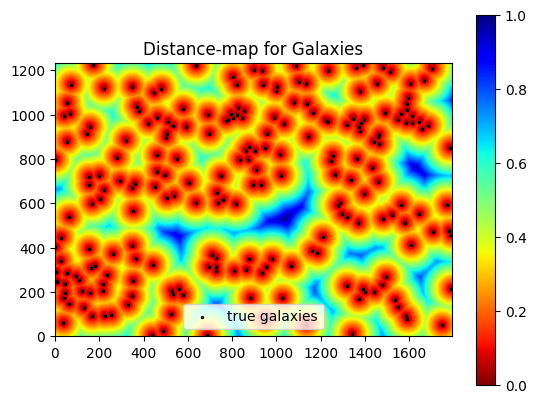

In [6]:
plot_distance_map(d_galaxies, "Galaxies", y_galaxies_coords, point_label='true galaxies')

tensor(0., dtype=torch.float16) tensor(1., dtype=torch.float16)


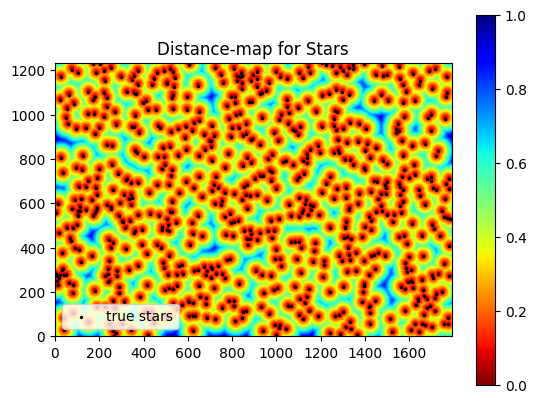

In [7]:
plot_distance_map(d_stars, "Stars", y_stars_coords, point_label='true stars')

## Results

In [8]:
from star_analysis.utils.constants import MODEL_DIR
import os

model = torch.load(os.path.join(MODEL_DIR, 'model-run-UNET-2023-06-30 00:17:11.130331.pt'))
model.eval()

UNetModel(
  (loss_fn): DADiceLoss()
  (architecture): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b

In [9]:
dataset_patched = Sdss(
    config=SdssDatasetConfig(
        patch_shape=(224, 224),
        prepare=True,
        include_test_set=True,
        include_train_set=False
    )
)
len(dataset_patched)

[INFO][2023-07-07 17:49:18,636] image_downloader.py:download_exact:62: Downloading 8162 6 0080


Found 1 data/label pairs


40

In [10]:
x_offset = 0 # dataset_patched.inner_padding
y_offset = 0 # dataset_patched.inner_padding

galaxies_preds = []
stars_preds = []
with torch.no_grad():
    for i in range(len(dataset_patched)):
        x = dataset_patched[i][0]
        x = x.permute(2, 0, 1)
        y_pred = model(x.unsqueeze(0)).squeeze(0)
        y_pred = y_pred.permute(1, 2, 0)
        # simulate predict step of model
        prob_mask = y_pred.sigmoid()
        pred_mask = (prob_mask > 0.5).float()
        y_galaxies_coords_pred = torch.nonzero(pred_mask[..., 0])
        y_stars_coords_pred = torch.nonzero(pred_mask[..., 1])
        # apply offset to coordinates relative to patch
        y_galaxies_coords_pred[:, 0] += x_offset
        y_galaxies_coords_pred[:, 1] += y_offset
        y_stars_coords_pred[:, 0] += x_offset
        y_stars_coords_pred[:, 1] += y_offset
        galaxies_preds.append(y_galaxies_coords_pred)
        stars_preds.append(y_stars_coords_pred)

        if x_offset + 2 * dataset_patched.patch_shape[0] <= dataset_patched.cropped_image_shape[0]:
            x_offset += dataset_patched.patch_shape[0]
        else:
            x_offset = 0
            y_offset += dataset_patched.patch_shape[1]

    # flatten list of tensors
    galaxies_preds = torch.cat(galaxies_preds)
    stars_preds = torch.cat(stars_preds)


In [11]:
print(f'Galaxies {galaxies_preds.shape[0]} of {y_galaxies_coords.shape[0]}')

Galaxies 145 of 222


tensor(0., dtype=torch.float16) tensor(1., dtype=torch.float16)


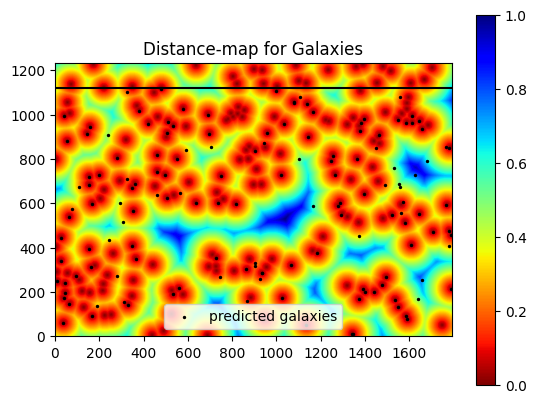

In [12]:
plot_distance_map(d_galaxies, "Galaxies", galaxies_preds, end_x=dataset_patched.cropped_image_shape[0], end_y=dataset_patched.cropped_image_shape[1], point_label='predicted galaxies')

In [13]:
print(f'Stars {stars_preds.shape[0]} of {y_stars_coords.shape[0]}')

Stars 454 of 708


tensor(0., dtype=torch.float16) tensor(1., dtype=torch.float16)


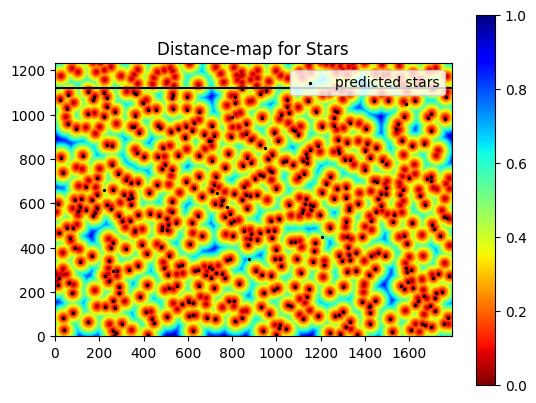

In [14]:
plot_distance_map(d_stars, "Stars", stars_preds, end_x=dataset_patched.cropped_image_shape[0], end_y=dataset_patched.cropped_image_shape[1], point_label='predicted stars')

In [15]:
x_background, _ = dataset[0]
x_background = x_background[..., 1:4].permute(1, 0, 2)[:, :, [0, 1, 2]]
x_background.shape

torch.Size([1233, 1792, 3])

[WARNING][2023-07-07 17:49:39,184] image.py:set_data:720: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.2827) tensor(316.5000)


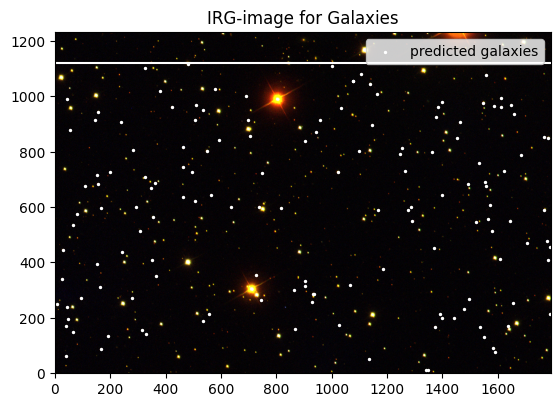

In [16]:
plot_distance_map(x_background, "Galaxies", galaxies_preds, end_x=dataset_patched.cropped_image_shape[0], end_y=dataset_patched.cropped_image_shape[1], point_label='predicted galaxies')

[WARNING][2023-07-07 17:49:39,675] image.py:set_data:720: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.2827) tensor(316.5000)


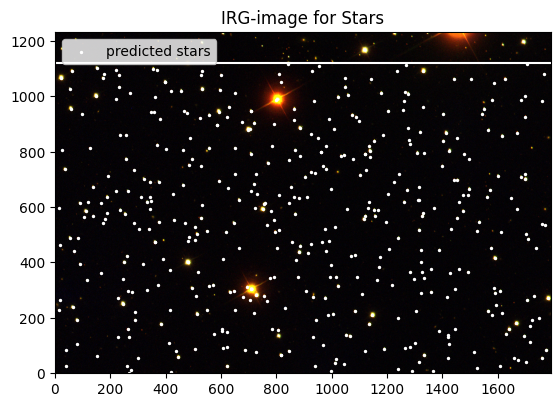

In [17]:
plot_distance_map(x_background, "Stars", stars_preds, end_x=dataset_patched.cropped_image_shape[0], end_y=dataset_patched.cropped_image_shape[1], point_label='predicted stars')